# 순환 신경망 RNN 구현

In [2]:
import numpy as np

In [4]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cacahe = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dwx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = dWb
        
        return dx, dh_prev

In [5]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        def __init__(self, Wx, Wh, b, stateful=False):
            self.params = [Wx, Wh, b]
            self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
            self.layers = None
            
            self.h, self.dh = None, None
            self.stateful = stateful
            
        def set_state(self, h):
            self.h = h
        
        def reset_state(self):
            self.h = None
            
        def forward(self, xs):
            Wx, Wh, b = self.params
            N, T, D = xs.shape
            D, H = Wx.shape
            
            self.layers = []
            hs = np.empty((N, T, H), dtype='f')
            
            if not self.stateful or self.h is None:
                self.h = zp.zeros((N, H), dtype='f')
                
            for t in range(T):
                layer = RNN(*self.params)
                self.h = layer.forward(xs[:, t, :], self.h)
                hs[:, t, :] = self.h
                self.layers.append(layer)
            
            return hs
        
        def backward(self, dhs):
            Wx, Wh, b = self.params
            N, T, H = dhs.shape
            D, H = Wx.shape
            
            dxs = np.empty((N, T, D), dtype='f')
            dh = 0
            grads = [0, 0, 0]
            for t in reversed(range(T)):
                layer = self.layers[t]
                dx, dh = layer.backward(dhs[:, t, :] + dh) # dht + dhnext 합산된 기울기
                dxs[:, t, :] = dx
                
                for i, grad in enumerate(layer.grads):
                    grads[i] += grad
            
            for i, grad in enumerate(grads):
                self.grads[i][...] = grad
            self.dh = dh
            
            return dxs

# 시계열 데이터 처리 계층 구현 RNNLM

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # Xavier 초기화
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [8]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기 (전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 에폭마다 퍼블렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼블렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼블렉서티 385.18
| 에폭 2 | 퍼블렉서티 254.02
| 에폭 3 | 퍼블렉서티 220.10
| 에폭 4 | 퍼블렉서티 212.82
| 에폭 5 | 퍼블렉서티 204.32
| 에폭 6 | 퍼블렉서티 201.33
| 에폭 7 | 퍼블렉서티 197.98
| 에폭 8 | 퍼블렉서티 196.25
| 에폭 9 | 퍼블렉서티 191.74
| 에폭 10 | 퍼블렉서티 192.63
| 에폭 11 | 퍼블렉서티 189.32
| 에폭 12 | 퍼블렉서티 192.85
| 에폭 13 | 퍼블렉서티 190.21
| 에폭 14 | 퍼블렉서티 190.35
| 에폭 15 | 퍼블렉서티 189.87
| 에폭 16 | 퍼블렉서티 186.56
| 에폭 17 | 퍼블렉서티 184.24
| 에폭 18 | 퍼블렉서티 181.12
| 에폭 19 | 퍼블렉서티 183.00
| 에폭 20 | 퍼블렉서티 185.48
| 에폭 21 | 퍼블렉서티 181.98
| 에폭 22 | 퍼블렉서티 179.00
| 에폭 23 | 퍼블렉서티 177.41
| 에폭 24 | 퍼블렉서티 177.65
| 에폭 25 | 퍼블렉서티 175.21
| 에폭 26 | 퍼블렉서티 176.78
| 에폭 27 | 퍼블렉서티 171.58
| 에폭 28 | 퍼블렉서티 169.52
| 에폭 29 | 퍼블렉서티 171.08
| 에폭 30 | 퍼블렉서티 165.92
| 에폭 31 | 퍼블렉서티 165.47
| 에폭 32 | 퍼블렉서티 159.06
| 에폭 33 | 퍼블렉서티 161.06
| 에폭 34 | 퍼블렉서티 157.82
| 에폭 35 | 퍼블렉서티 155.80
| 에폭 36 | 퍼블렉서티 150.10
| 에폭 37 | 퍼블렉서티 145.90
| 에폭 38 | 퍼블렉서티 143.75
| 에폭 39 | 퍼블렉서티 136.60
| 에폭 40 | 퍼블렉서티 132.28
| 에폭 41 | 퍼블렉서티 133.78
| 에폭 42 | 퍼블렉서티 127.06
| 에폭 43 | 퍼블렉서티 119

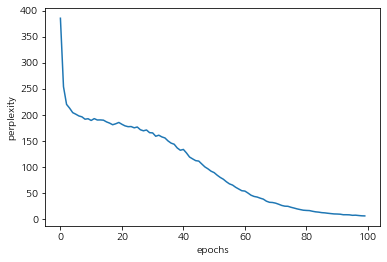

In [9]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

# RNNLM의 Trainer 클래스

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 419.19
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 385.30
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 265.95
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 222.54
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.74
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.71
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.67
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.63
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.88
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.24
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.00
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.04
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.26
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.45
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.58
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.62
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.34
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.94
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.51
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.62
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 176.80
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 175.

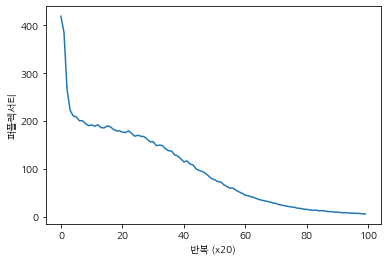

In [10]:
from common.trainer import RnnlmTrainer
from dataset import ptb


# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()